Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

Some visualization code in this notebook is based on [Arn-O's work](https://github.com/Arn-O/udacity-deep-learning/blob/master/1_notmnist.ipynb).

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the test set 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
            
        last_percent_reported = percent

def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for notMNIST_large. This may take a while. Please wait.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
Extracting data for notMNIST_small. This may take a while. Please wait.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
import random

def display_samples(folders, sample_size):
    """
    :param folders: a list of folder names
    :param sample_size: number of samples for each letter
    :return: the sample image
    """
    for folder in folders:
        print(folder)
        img_files = os.listdir(folder)
        sample = random.sample(img_files, sample_size)
        for img in sample:
            img_file = os.path.join(folder, img)
            image = Image(filename=img_file)
            display(image)

display_samples(train_folders, 1)

notMNIST_large/A


notMNIST_large/B


notMNIST_large/C


notMNIST_large/D


notMNIST_large/E


notMNIST_large/F


notMNIST_large/G


notMNIST_large/H


notMNIST_large/I


notMNIST_large/J


In [5]:
display_samples(test_folders, 1)

notMNIST_small/A


notMNIST_small/B


notMNIST_small/C


notMNIST_small/D


notMNIST_small/E


notMNIST_small/F


notMNIST_small/G


notMNIST_small/H


notMNIST_small/I


notMNIST_small/J


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviatiobn ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [6]:
import hashlib

image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images, remove_duplicates=True):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
    print(folder)
    
    num_images = 0
    
    if remove_duplicates:
        hash_codes = set()
        counter = 0

        for image in image_files:
            image_file = os.path.join(folder, image)
            try:
                with open(image_file, 'rb') as f:
                    hash_code = hashlib.md5(f.read()).hexdigest()  # get hash code for each image file
                    if hash_code in hash_codes: # remove duplicated image files, file with the same hash code
                        counter += 1
                    else:
                        hash_codes.add(hash_code)
                        image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
                        if image_data.shape != (image_size, image_size):
                            raise Exception('Unexpected image shape: %s' % str(image_data.shape))
                        dataset[num_images, :, :] = image_data
                        num_images += 1
            except IOError as e:
                print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        print('Number of duplicates removed:', counter)    
        dataset = dataset[0:num_images, :, :]
    
    else:
        for image_index, image in enumerate(image_files):
            image_file = os.path.join(folder, image)
            try:
                image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
                if image_data.shape != (image_size, image_size):
                    raise Exception('Unexpected image shape: %s' % str(image_data.shape))
                dataset[image_index, :, :] = image_data
            except IOError as e:
                print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        num_images = image_index
        dataset = dataset[0:num_images, :, :]


    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            print('')
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

train_datasets = maybe_pickle(train_folders, 40000)
test_datasets = maybe_pickle(test_folders, 1500)

Pickling notMNIST_large/A.pickle.
notMNIST_large/A
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Number of duplicates removed: 5805
Full dataset tensor: (47105, 28, 28)
Mean: -0.128145
Standard deviation: 0.442586

Pickling notMNIST_large/B.pickle.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Number of duplicates removed: 5629
Full dataset tensor: (47282, 28, 28)
Mean: -0.0103907
Standard deviation: 0.453911

Pickling notMNIST_large/C.pickle.
notMNIST_large/C
Number of duplicates removed: 6258
Full dataset tensor: (4

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

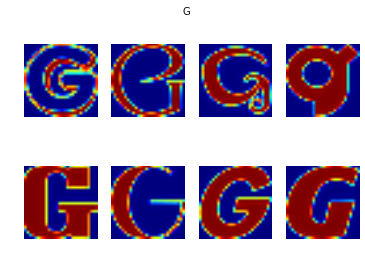

In [7]:
folder = random.sample(train_folders, 1)  # randomly select a folder from train folders
pickle_file = folder[0] + '.pickle'  # get the pickle file name
with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)  # get data array by loading pickle file

plt.suptitle(folder[0][-1])  # print the letter as title
for i, img in enumerate(random.sample(list(dataset), 8)):  # ranomly select 8 images to show
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(img)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

The data is balanced across classes means each class is represented relatively equally. Let's take a look on number of samples in each class.

In [8]:
# Check classes in training data
for folder in train_folders:
    pickle_file = folder + '.pickle'
    with open(pickle_file, 'rb') as f:
        dataset = pickle.load(f)
        print('Number of images in {0} is {1}.'.format(str(folder), len(dataset)) )

# Check classes in test data
for folder in test_folders:
    pickle_file = folder + '.pickle'
    with open(pickle_file, 'rb') as f:
        dataset = pickle.load(f)
        print('Number of images in {0} is {1}.'.format(str(folder), len(dataset)) )

Number of images in notMNIST_large/A is 47105.
Number of images in notMNIST_large/B is 47282.
Number of images in notMNIST_large/C is 46654.
Number of images in notMNIST_large/D is 46733.
Number of images in notMNIST_large/E is 46954.
Number of images in notMNIST_large/F is 46844.
Number of images in notMNIST_large/G is 47090.
Number of images in notMNIST_large/H is 46183.
Number of images in notMNIST_large/I is 41173.
Number of images in notMNIST_large/J is 46658.
Number of images in notMNIST_small/A is 1848.
Number of images in notMNIST_small/B is 1853.
Number of images in notMNIST_small/C is 1849.
Number of images in notMNIST_small/D is 1847.
Number of images in notMNIST_small/E is 1847.
Number of images in notMNIST_small/F is 1850.
Number of images in notMNIST_small/G is 1851.
Number of images in notMNIST_small/H is 1846.
Number of images in notMNIST_small/I is 1597.
Number of images in notMNIST_small/J is 1850.


All classes are approximately equally represented by relatively same number of samples in training and test data respectively, hence our data is balanced.

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [9]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class

                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise

    return valid_dataset, valid_labels, train_dataset, train_labels

            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [10]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

To show the data is still good, let's check if the images are right.

Check training set


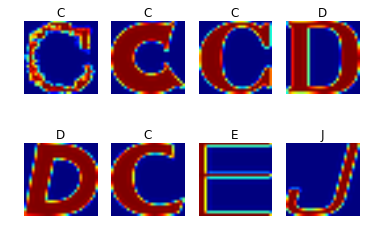

In [11]:
letters = 'ABCDEFGHIJ'
print('Check training set')
img_indices = random.sample(range(len(train_dataset)), 8)  # randomly select 8 images from train dataset

for i, img in enumerate(img_indices):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.title(letters[train_labels[img]])
    plt.imshow(train_dataset[img])

Check validation set


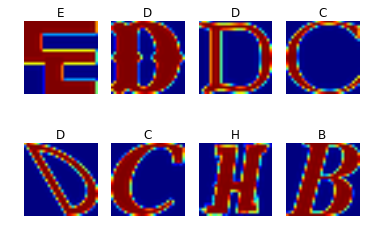

In [12]:
print('Check validation set')
img_indices = random.sample(range(len(valid_dataset)), 8)  # randomly select 8 images from train dataset

for i, img in enumerate(img_indices):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.title(letters[valid_labels[img]])
    plt.imshow(valid_dataset[img])

Check test set


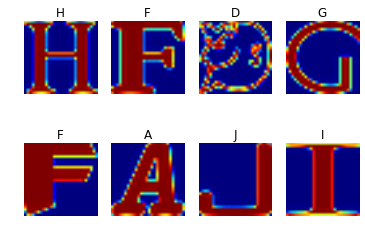

In [13]:
print('Check test set')
img_indices = random.sample(range(len(test_dataset)), 8)  # randomly select 8 images from train dataset

for i, img in enumerate(img_indices):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.title(letters[test_labels[img]])
    plt.imshow(test_dataset[img])

Finally, let's save the data for later reuse:

In [14]:
pickle_file = 'notMNIST.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [15]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800512


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

Duplicates can be removed when loading the image files. See `remove_duplicates` option in function `load_letter()`.

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [16]:
logreg = LogisticRegression(random_state=0)

In [17]:
# sklearn's LogisticRegression() requires the dataset array with dimensions <= 2.
# we need to reshape the training and test datasets by combining x, y pixels

X_test = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
y_test = test_labels

In [18]:
# Training size = 50
X_train_50 = train_dataset[:50].reshape(50, 28 * 28)
y_train_50 = train_labels[:50]

%time logreg.fit(X_train_50, y_train_50)
score_50 = logreg.score(X_test, y_test)
print('Score of using 50 training samples is {}.'.format(score_50))

CPU times: user 50.8 ms, sys: 2.12 ms, total: 52.9 ms
Wall time: 51 ms
Score of using 50 training samples is 0.5999.


In [19]:
# Training size = 100
X_train_100 = train_dataset[:100].reshape(100, 28 * 28)
y_train_100 = train_labels[:100]

%time logreg.fit(X_train_100, y_train_100)
score_100 = logreg.score(X_test, y_test)
print('Score of using 100 training samples is {}.'.format(score_100))

CPU times: user 136 ms, sys: 4.17 ms, total: 140 ms
Wall time: 138 ms
Score of using 100 training samples is 0.734.


In [20]:
# Training size = 1000
X_train_1000 = train_dataset[:1000].reshape(1000, 28 * 28)
y_train_1000 = train_labels[:1000]

%time logreg.fit(X_train_1000, y_train_1000)
score_1000 = logreg.score(X_test, y_test)
print('Score of using 1000 training samples is {}.'.format(score_1000))

CPU times: user 2.89 s, sys: 24.8 ms, total: 2.91 s
Wall time: 2.93 s
Score of using 1000 training samples is 0.8241.


In [21]:
# Training size = 5000
X_train_5000 = train_dataset[:5000].reshape(5000, 28 * 28)
y_train_5000 = train_labels[:5000]

%time logreg.fit(X_train_5000, y_train_5000)
score_5000 = logreg.score(X_test, y_test)
print('Score of using 5000 training samples is {}.'.format(score_5000))

CPU times: user 39.4 s, sys: 340 ms, total: 39.7 s
Wall time: 48.6 s
Score of using 5000 training samples is 0.8408.


In [22]:
# Training size = 10000
X_train_10000 = train_dataset[:10000].reshape(10000, 28 * 28)
y_train_10000 = train_labels[:10000]

%time logreg.fit(X_train_10000, y_train_10000)
score_10000 = logreg.score(X_test, y_test)
print('Score of using 10000 training samples is {}.'.format(score_10000))

CPU times: user 1min 8s, sys: 487 ms, total: 1min 8s
Wall time: 1min 11s
Score of using 10000 training samples is 0.8531.


In [23]:
# use all training samples, takes long
X_train_all = train_dataset.reshape(train_dataset.shape[0], 28 * 28)
y_train_all = train_labels

%time logreg.fit(X_train_all, y_train_all)
score_all = logreg.score(X_test, y_test)
print('Score of using all training samples is {}.'.format(score_all))

CPU times: user 29min 49s, sys: 16.4 s, total: 30min 6s
Wall time: 30min 25s
Score of using all training samples is 0.8907.


<function matplotlib.pyplot.show>

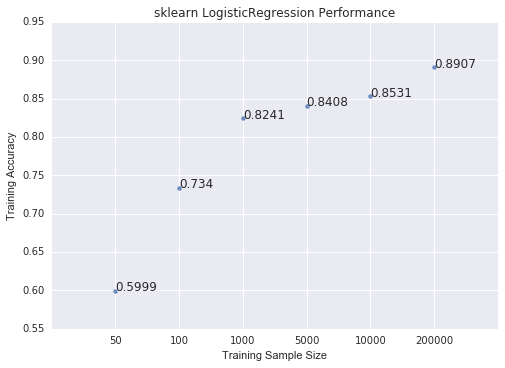

In [24]:
import seaborn as sns

sample_sizes = np.array(['50', '100', '1000', '5000', '10000', str(train_dataset.shape[0])])
reg_scores = np.array([score_50, score_100, score_1000, score_5000, score_10000, score_all])
x_axis = np.array(range(6))

sns.regplot(x_axis, reg_scores, fit_reg=False)
plt.xticks(x_axis, sample_sizes)
plt.title('sklearn LogisticRegression Performance')
plt.xlabel('Training Sample Size')
plt.ylabel('Training Accuracy')
for i, txt in enumerate(reg_scores):
    plt.annotate(txt, (x_axis[i], reg_scores[i]))
plt.show

The best performance of an off-the-shelf model, `sklearn.linear_model.LogisticRegression`, approaces to 0.9 which occurs when all training samples are used.